In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from collections import defaultdict
from music21 import converter, corpus, instrument, midi, note, chord, pitch
from notebook.services.config import ConfigManager


cm = ConfigManager().update('notebook', {'limit_output': 1000})

path = "../Data"
dir_list = os.listdir(path)
midi_dict = defaultdict(dict)

In [ ]:
from collections import deque

def delete_file(dir_list:list, file_name) -> list:

    queue = deque(dir_list)
    answer = []

    while queue:
        temp = queue.popleft()
        if file_name  in temp:
            continue
        else:
            answer.append(temp)
    return answer

In [2]:
def get_composer_list(dir_list:list):

    for era in dir_list:
        era_path = path+"/"+era
        composer_list = os.listdir(era_path)

        for composer in composer_list:
            midi_dict[era][composer] = []

In [3]:
get_composer_list(dir_list)

print(midi_dict)

defaultdict(<class 'dict'>, {'Baroque': {'Antonio Vivaldi': [], 'Claudio Monteverdi': [], 'George Frideric Handel': [], 'Johann Sebastian Bach': []}, 'Classic': {'Bethoven': [], 'Franz Joseph Haydn': [], 'Franz Shubert': [], 'Wolfgang Amadeus Mozart': []}, 'Romantic': {'Fredric Chopin': [], 'Giuseppe Verdi': [], 'Johannes Brahms': [], 'Pyotr Tchaikovsky': []}})


In [4]:
for era, composer_dict in midi_dict.items():
    for composer in composer_dict:
        temp_path = path+"/"+era+"/"+composer
        
        song_list = os.listdir(temp_path)
        song_list = delete_file(song_list, ".png")
        song_list = delete_file(song_list, ".txt")

        midi_dict[era][composer] = song_list

In [5]:
midi_dict

defaultdict(dict,
            {'Baroque': {'Antonio Vivaldi': ['lastravaganza.mid',
               'lastravaganza.png',
               'lastravaganza.txt',
               'spring.mid',
               'spring.png',
               'spring.txt',
               'summer.mid',
               'summer.png',
               'summer.txt'],
              'Claudio Monteverdi': ['bacicari.mid',
               'bacicari.png',
               'bacicari.txt',
               'giovinetta.mid',
               'giovinetta.png',
               'giovinetta.txt',
               'sevoi.mid',
               'sevoi.png',
               'sevoi.txt'],
              'George Frideric Handel': ['HWV312.mid',
               'HWV312.png',
               'HWV312.txt',
               'HWV313.mid',
               'HWV313.png',
               'HWV313.txt',
               'messiah.mid',
               'messiah.png',
               'messiah.txt'],
              'Johann Sebastian Bach': ['BWV525.mid',
               'BWV525.pn

In [6]:
def print_parts_countour(midi, img_path, txt_path, instrument_list):
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(1, 1, 1)
    minPitch = pitch.Pitch('C10').ps
    maxPitch = 0
    xMax = 0
    

    collect_x = []
    collect_y = []

    # Drawing notes.
    for i in range(len(midi.parts)):
        top = midi.parts[i].flat.notes                  
        y, parent_element = extract_notes(top)
        if (len(y) < 1): continue
            
        x = [n.offset for n in parent_element]

        collect_x.append(x)
        collect_y.append(y)

        ax.scatter(x, y, alpha=0.6, s=7)
        
        aux = min(y)
        if (aux < minPitch): minPitch = aux
            
        aux = max(y)
        if (aux > maxPitch): maxPitch = aux
            
        aux = max(x)
        if (aux > xMax): xMax = aux

    for i in range(1, 10):
        linePitch = pitch.Pitch('C{0}'.format(i)).ps
        if (linePitch > minPitch and linePitch < maxPitch):
            ax.add_line(mlines.Line2D([0, xMax], [linePitch, linePitch], color='red', alpha=0.1))            

    plt.ylabel("Note index (each octave has 12 notes)")
    plt.xlabel("Number of quarter notes (beats)")
    plt.title('Voices motion approximation, each color is a different instrument, red lines show each octave')
    plt.savefig(img_path, dpi=500)
    
    
    
    plt.show()

    # # print(collect_x)
    # # print(collect_y)
    # # print("length : ",  len(collect_x), len(collect_y))
    # for x, y in zip(collect_x, collect_y):
    #     print(x,y)
    # print(minPitch)
    # print(maxPitch)
    # print(xMax)


    with open(txt_path, "w") as f:
        
        f.write("Notes\n")
        for i, data in enumerate(zip(collect_x, collect_y)):
            for x_data, y_data in zip(data[0], data[1]):
                f.write(str(x_data) + " " + str(y_data)+"\n")

        f.write("minPitch\n"+str(minPitch)+"\n")
        f.write("maxPitch\n"+str(maxPitch)+"\n")
        f.write("xMax\n"+str(xMax)+"\n")
        f.write("instrument_count\n"+str(i+1)+"\n")

        for inst in instrument_list:
            f.write(str(inst) +"\n")

        f.write("end")

In [7]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

In [8]:
def list_instruments(midi):

    instrument_list = []

    partStream = midi.parts.stream()
    # print("List of instruments found on MIDI file:")
    for p in partStream:
        aux = p
        instrument_list.append(p.partName)
        # print (p.partName)

    return instrument_list

In [9]:
def extract_notes(midi_part):
    parent_element = []
    ret = []
    for nt in midi_part.flat.notes:        
        if isinstance(nt, note.Note):
            ret.append(max(0.0, nt.pitch.ps))
            parent_element.append(nt)
        elif isinstance(nt, chord.Chord):
            for pitch in nt.pitches:
                ret.append(max(0.0, pitch.ps))
                parent_element.append(nt)
    
    return ret, parent_element


In [9]:
# Baroque Data

for era, composer_dict in midi_dict.items():
    
    print("Era: ", era)
    
    if era == "Baroque":   
        for composer, song_list in composer_dict.items():
            for i, song in enumerate(song_list):
                midi_path = path + "/" + era + "/" + composer + "/" + song_list[i]
                print(midi_path)
                midi_dict[era][composer][i]= [song_list[i],open_midi(midi_path,True)]
                
        break
        
        
for composer, song_list in composer_dict.items():
    for i, song in enumerate(song_list):
        midi_path = path + "/" + era + "/" + composer + "/" + song[0]   

        temp_path = "".join(midi_path.split(".")[:-1])
        jpg_path = ".." + temp_path + ".png"
        txt_path = ".." + temp_path + ".txt"

        print(jpg_path)
        
        instruments_list = list_instruments(song[1]) 
        print_parts_countour(song[1], jpg_path, txt_path, instruments_list)            

Era:  Baroque
../Data/Baroque/Antonio Vivaldi/lastravaganza.mid
../Data/Baroque/Antonio Vivaldi/spring.mid
../Data/Baroque/Antonio Vivaldi/summer.mid
../Data/Baroque/Claudio Monteverdi/bacicari.mid
../Data/Baroque/Claudio Monteverdi/giovinetta.mid
../Data/Baroque/Claudio Monteverdi/sevoi.mid
../Data/Baroque/George Frideric Handel/HWV312.mid
../Data/Baroque/George Frideric Handel/HWV313.mid
../Data/Baroque/George Frideric Handel/messiah.mid
../Data/Baroque/Johann Sebastian Bach/BWV525.mid
../Data/Baroque/Johann Sebastian Bach/BWV529.mid
../Data/Baroque/Johann Sebastian Bach/BWV530.mid


In [10]:
composer_dict

{'Fredric Chopin': ['fminorop21.mid',
  'gsharpminorop25.mid',
  'no1eminorop11.mid',
  'op10no3.mid'],
 'Giuseppe Verdi': ['diesiraerequiem.mid',
  'sanctusrequiem.mid',
  'Stringquarteteminor.mid'],
 'Johannes Brahms': ['fmajorno3.mid'],
 'Pyotr Tchaikovsky': ['nutcrackermarche.mid',
  'nutcrackerop71.mid',
  'nutcrackeroverture.mid']}

In [11]:
# Romantic Data

for era, composer_dict in midi_dict.items():
    print(era)
    
    if era == "Romantic":   
        
        print("Era: ", era)
        for composer, song_list in composer_dict.items():
            for i, song in enumerate(song_list):
                midi_path = path + "/" + era + "/" + composer + "/" + song_list[i]
                print(midi_path)
                midi_dict[era][composer][i]= [song_list[i],open_midi(midi_path,True)]
                
        break
        
for composer, song_list in composer_dict.items():
    for i, song in enumerate(song_list):
        midi_path = path + "/" + era + "/" + composer + "/" + song[0]   

        temp_path = "".join(midi_path.split(".")[:-1])
        jpg_path = ".." + temp_path + ".png"
        txt_path = ".." + temp_path + ".txt"

        print(jpg_path)
        
        instruments_list = list_instruments(song[1]) 
        print_parts_countour(song[1], jpg_path, txt_path, instruments_list)       

Baroque
Classic
Romantic
Era:  Romantic
../Data/Romantic/Fredric Chopin/fminorop21.mid
../Data/Romantic/Fredric Chopin/gsharpminorop25.mid
../Data/Romantic/Fredric Chopin/no1eminorop11.mid
../Data/Romantic/Fredric Chopin/op10no3.mid
../Data/Romantic/Giuseppe Verdi/diesiraerequiem.mid
../Data/Romantic/Giuseppe Verdi/sanctusrequiem.mid
../Data/Romantic/Giuseppe Verdi/Stringquarteteminor.mid
../Data/Romantic/Johannes Brahms/fmajorno3.mid


C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Symphonie Nr.3 in F dur f\xfcr grosses Orchester, Op.90'>; getting generic Instrument
  warnings.warn(
C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=1, channel=None, data=b'2 Fl\xf6ten'>; getting generic Instrument
  warnings.warn(
C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, channel=None, data=b'H\xf6rner I II in C'>; getting generic Instrument
  warnings.warn(
C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to dete

../Data/Romantic/Pyotr Tchaikovsky/nutcrackermarche.mid
../Data/Romantic/Pyotr Tchaikovsky/nutcrackerop71.mid


C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'2.b  Danse de la F\xe9e-Drag\xe9e'>; getting generic Instrument
  warnings.warn(


../Data/Romantic/Pyotr Tchaikovsky/nutcrackeroverture.mid


Baroque
Classic
Era:  Classic
../Data/Classic/Bethoven/no1fminorop2.mid
../Data/Classic/Bethoven/no2csharpminorop2.mid
../Data/Classic/Bethoven/no3cmmajorop2.mid
../Data/Classic/Franz Joseph Haydn/hobxvl8.mid
../Data/Classic/Franz Joseph Haydn/hobxvl9.mid
../Data/Classic/Franz Joseph Haydn/hobxvlg1.mid
../Data/Classic/Franz Shubert/d279.mid
../Data/Classic/Franz Shubert/d537.mid
../Data/Classic/Franz Shubert/d557.mid
../Data/Classic/Wolfgang Amadeus Mozart/kv310.mid
../Data/Classic/Wolfgang Amadeus Mozart/kv330.mid
../Data/Classic/Wolfgang Amadeus Mozart/kv331.mid


C:\Users\jungwoo\Desktop\Projects\venv\lib\site-packages\music21\midi\translate.py:863: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b'Mozart\x81@Piano Sonate A dur  K.331 \x91\xe6\x82P\x8ay\x8f\xcd'>; getting generic Instrument
  warnings.warn(


../Data/Classic/Bethoven/no1fminorop2.png


C:\Users\jungwoo\AppData\Local\Temp\ipykernel_14600\2722603731.py:4: StreamIteratorInefficientWarning: flat is not defined on StreamIterators. Call .stream() first for efficiency
  for nt in midi_part.flat.notes:


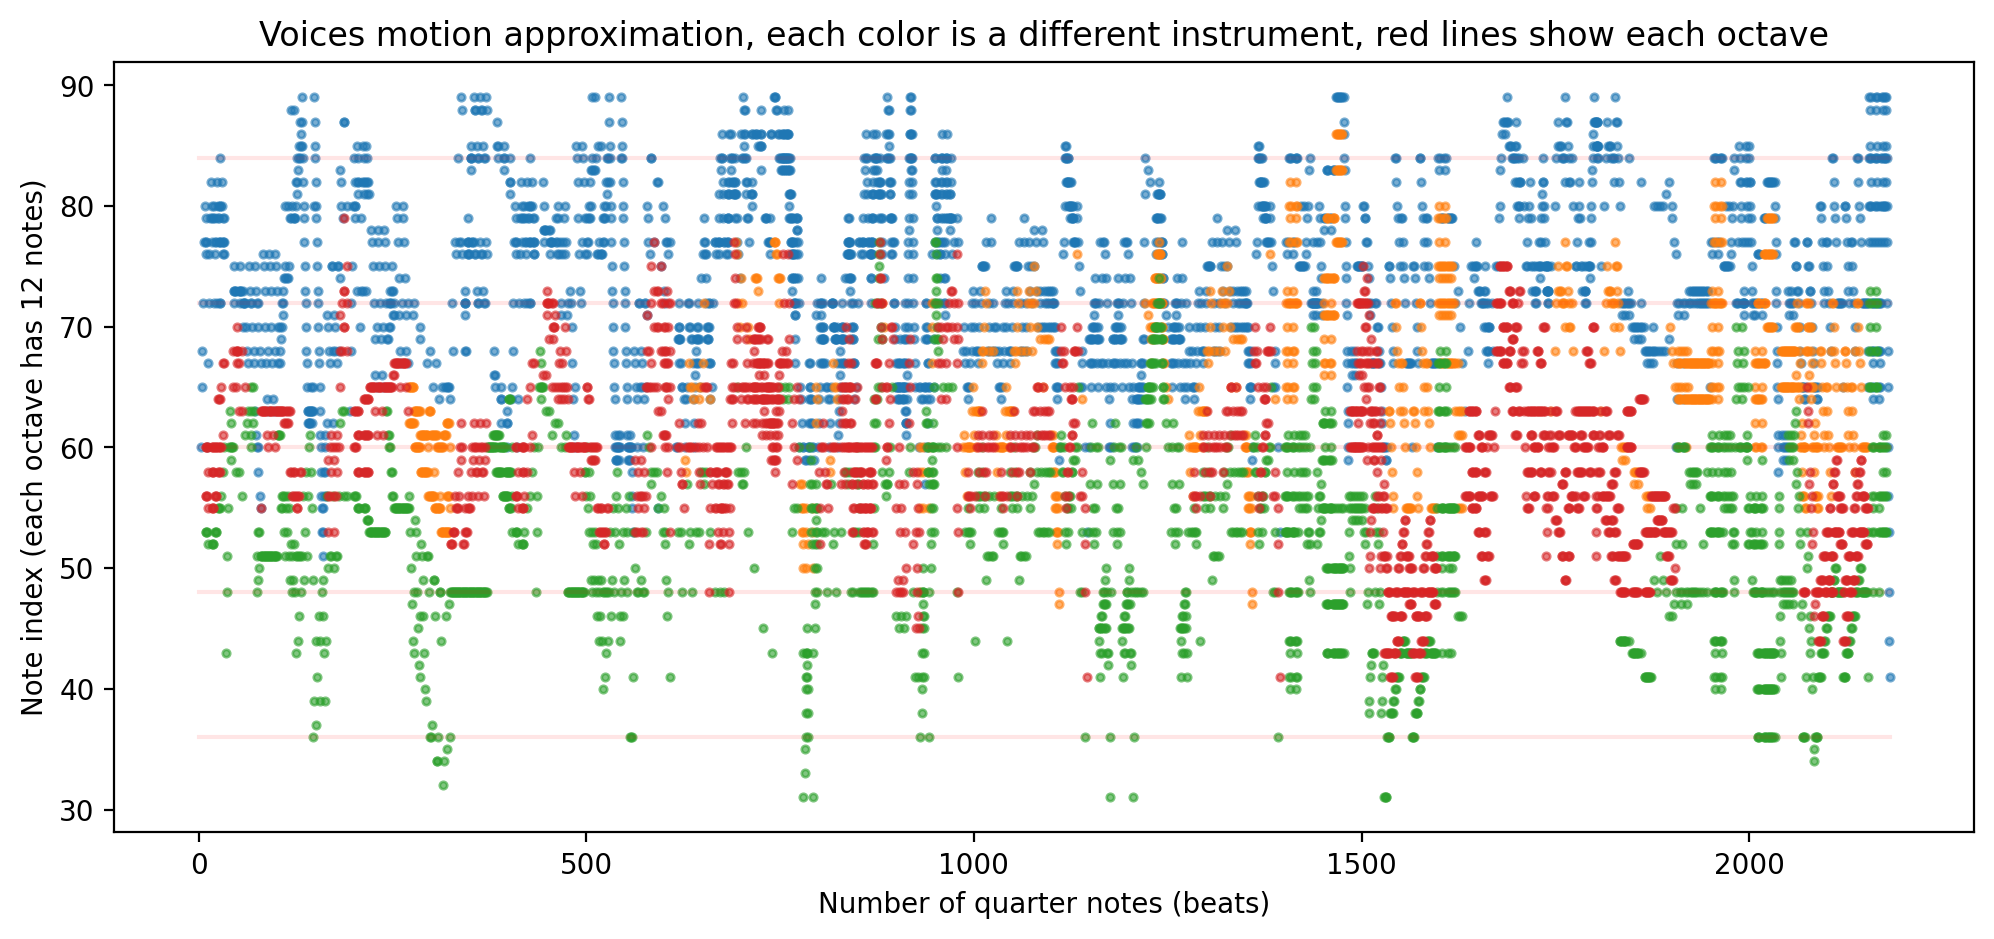

../Data/Classic/Bethoven/no2csharpminorop2.png


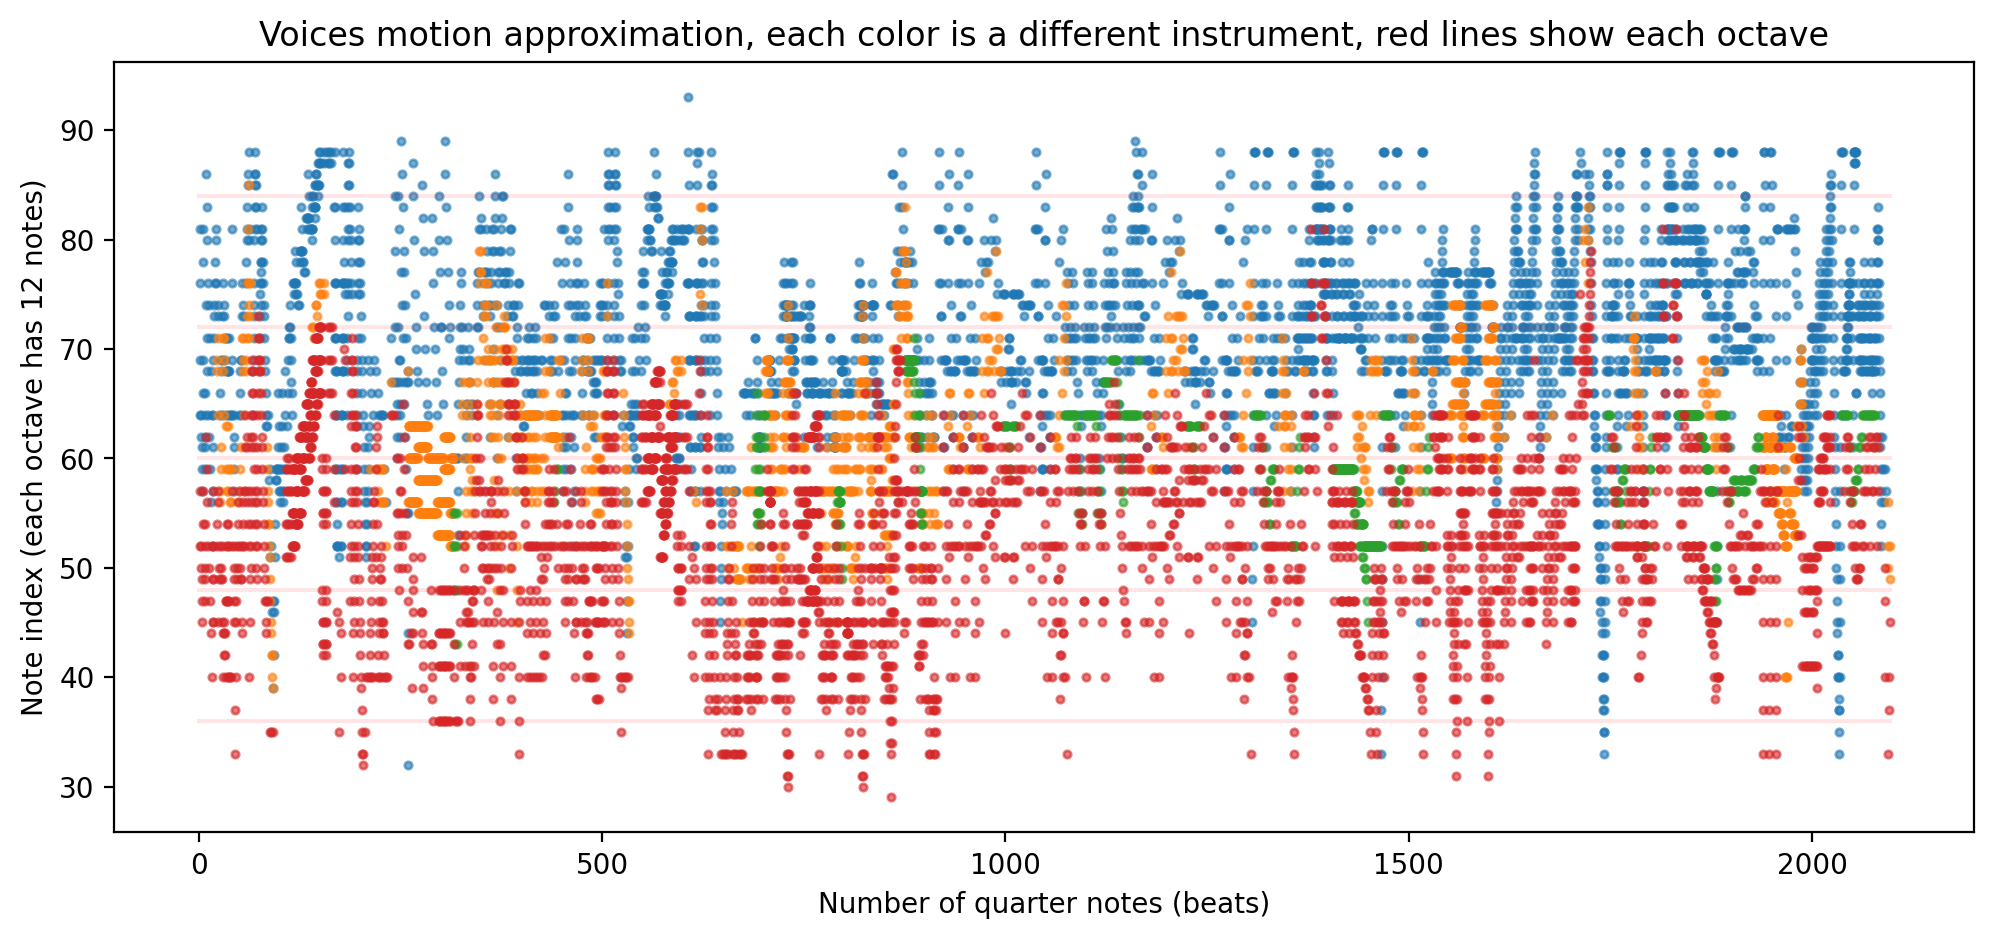

../Data/Classic/Bethoven/no3cmmajorop2.png


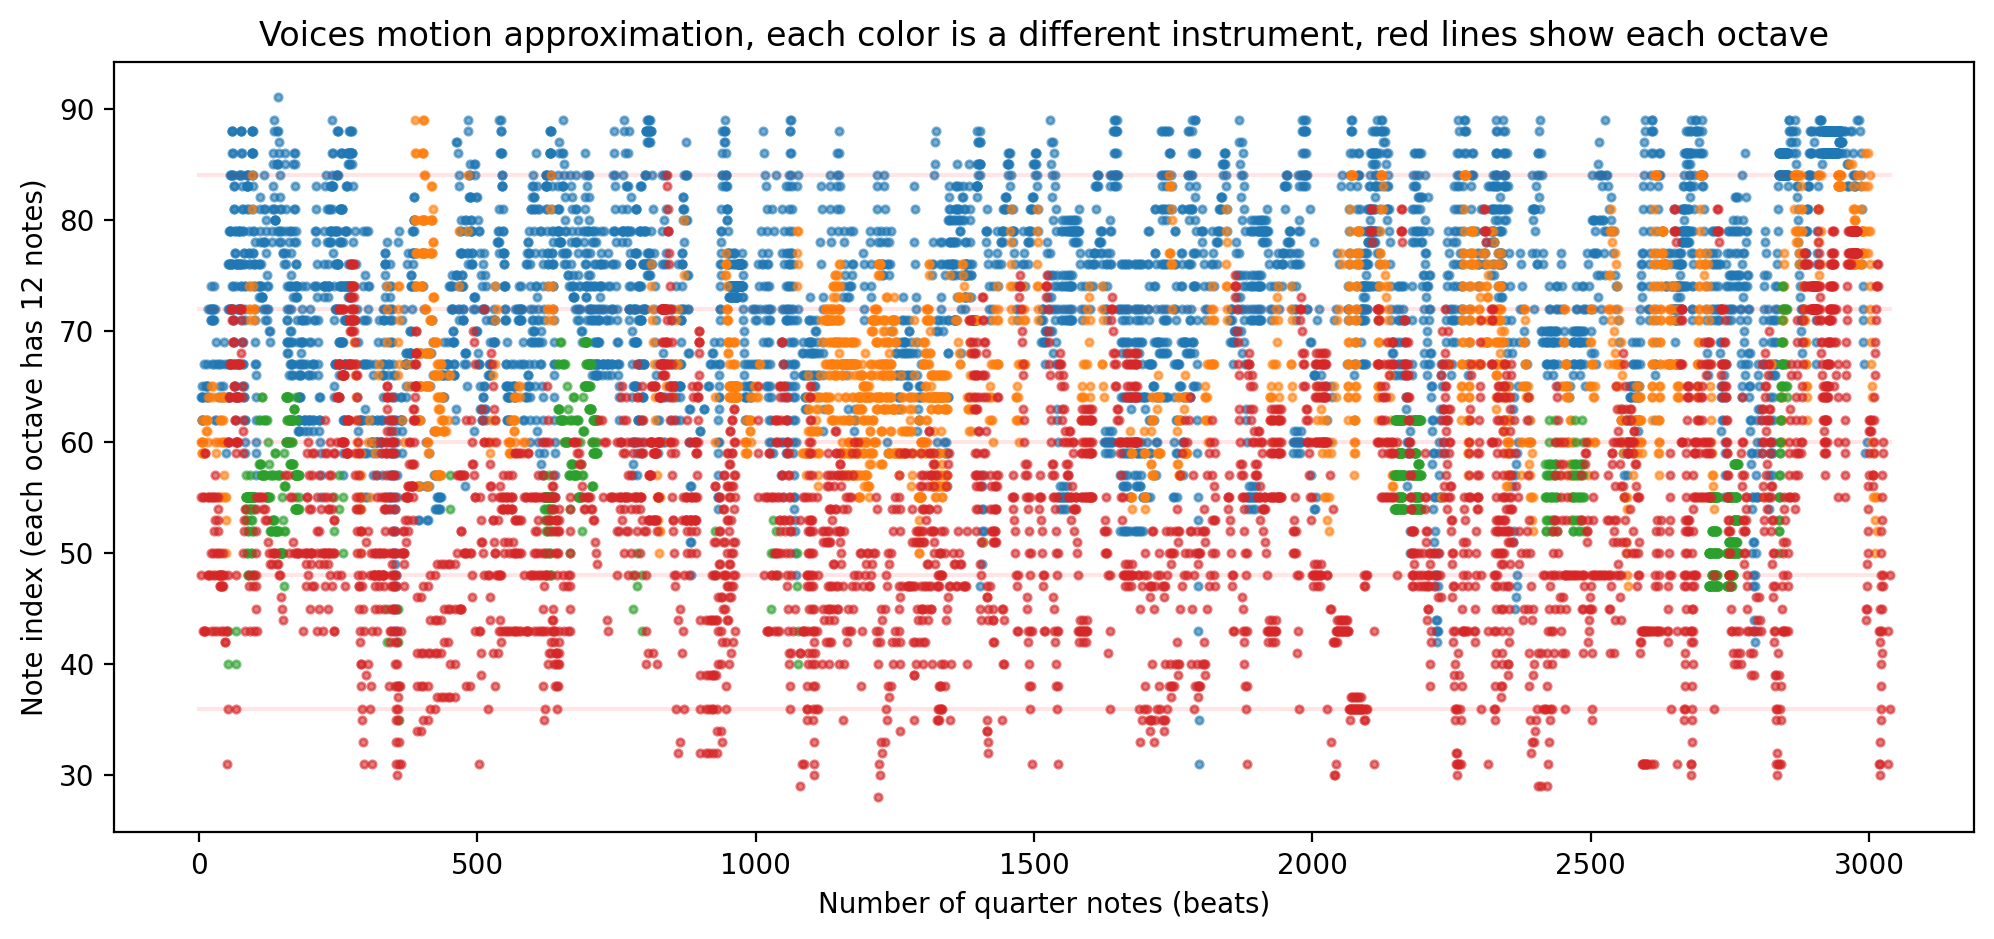

../Data/Classic/Franz Joseph Haydn/hobxvl8.png


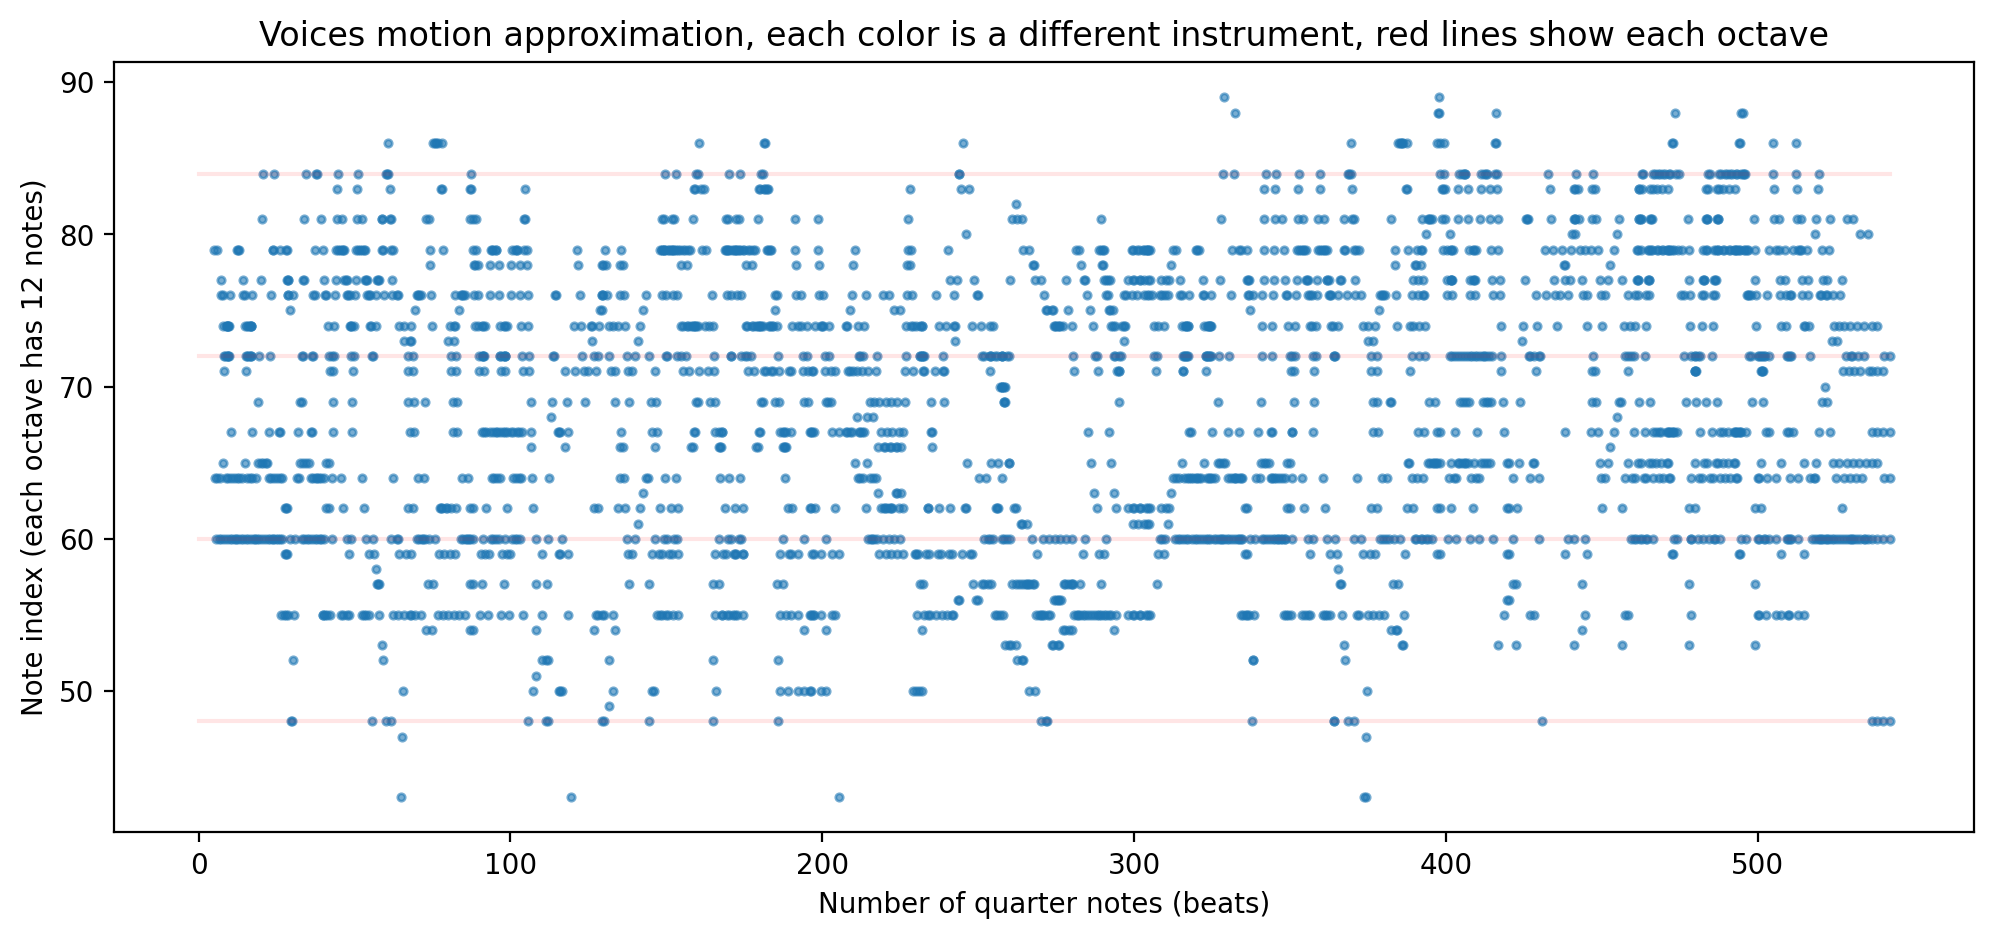

../Data/Classic/Franz Joseph Haydn/hobxvl9.png


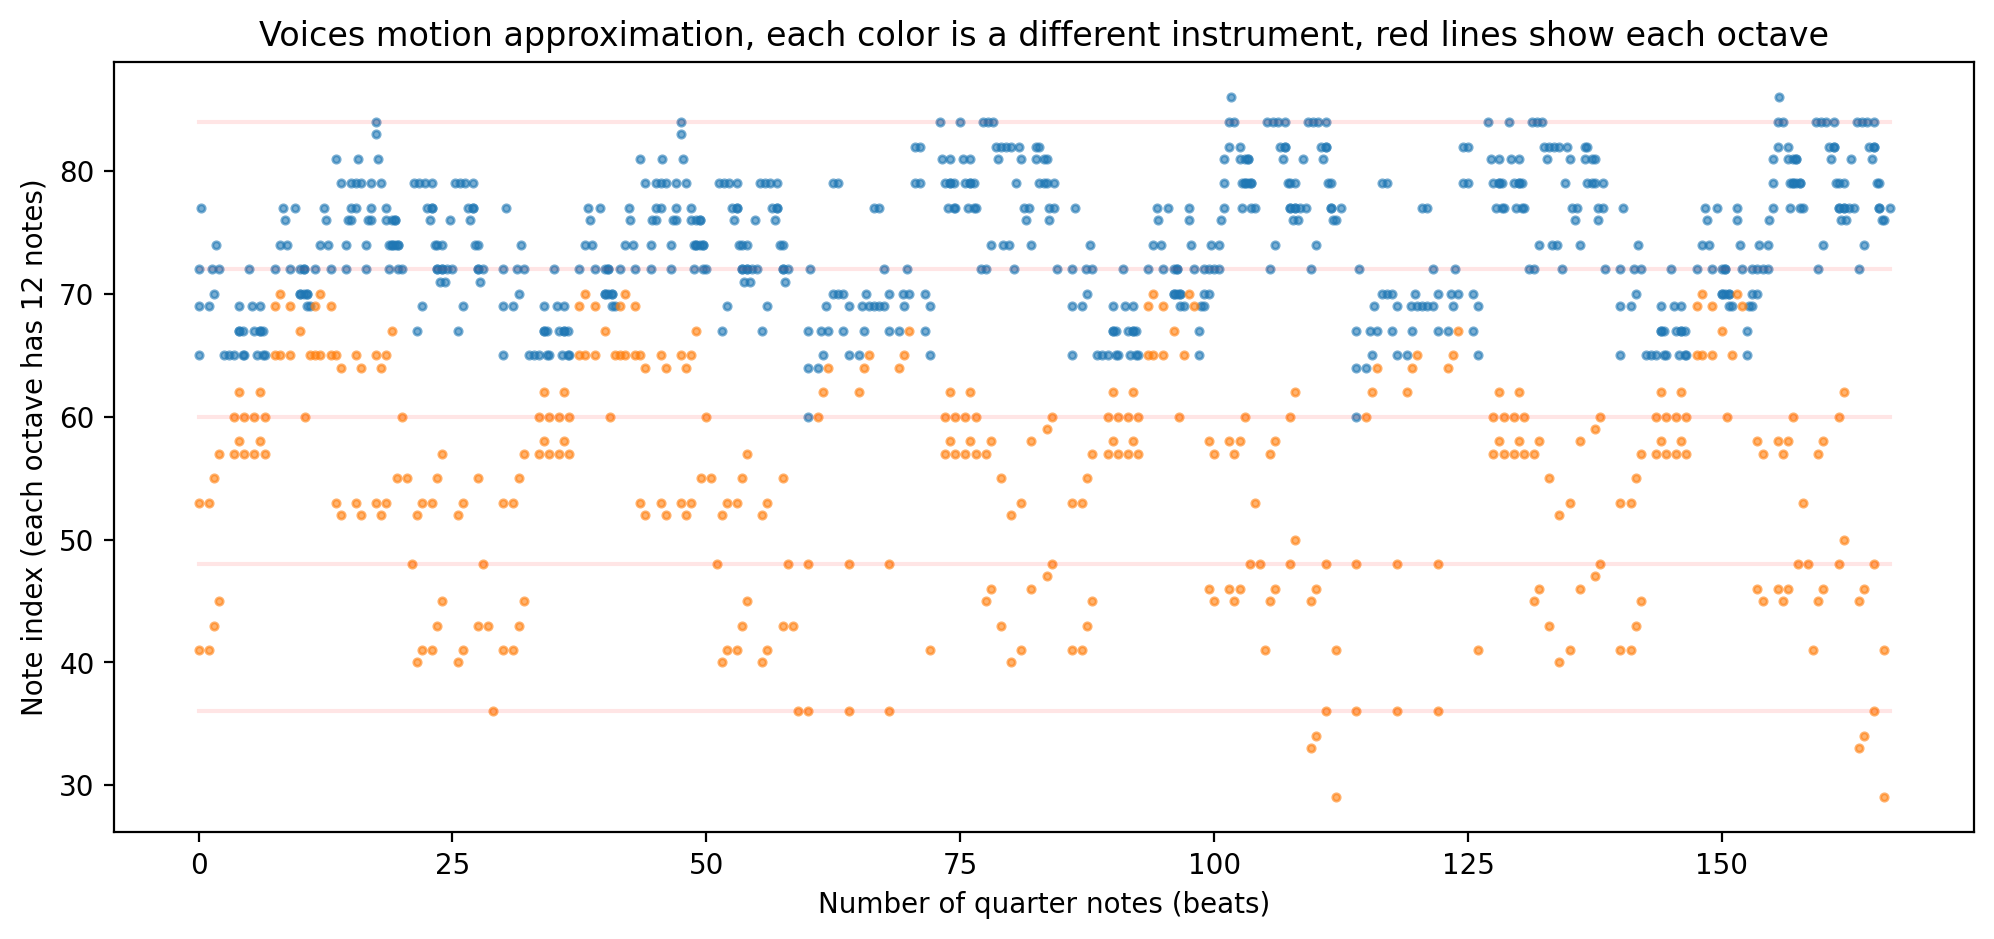

../Data/Classic/Franz Joseph Haydn/hobxvlg1.png


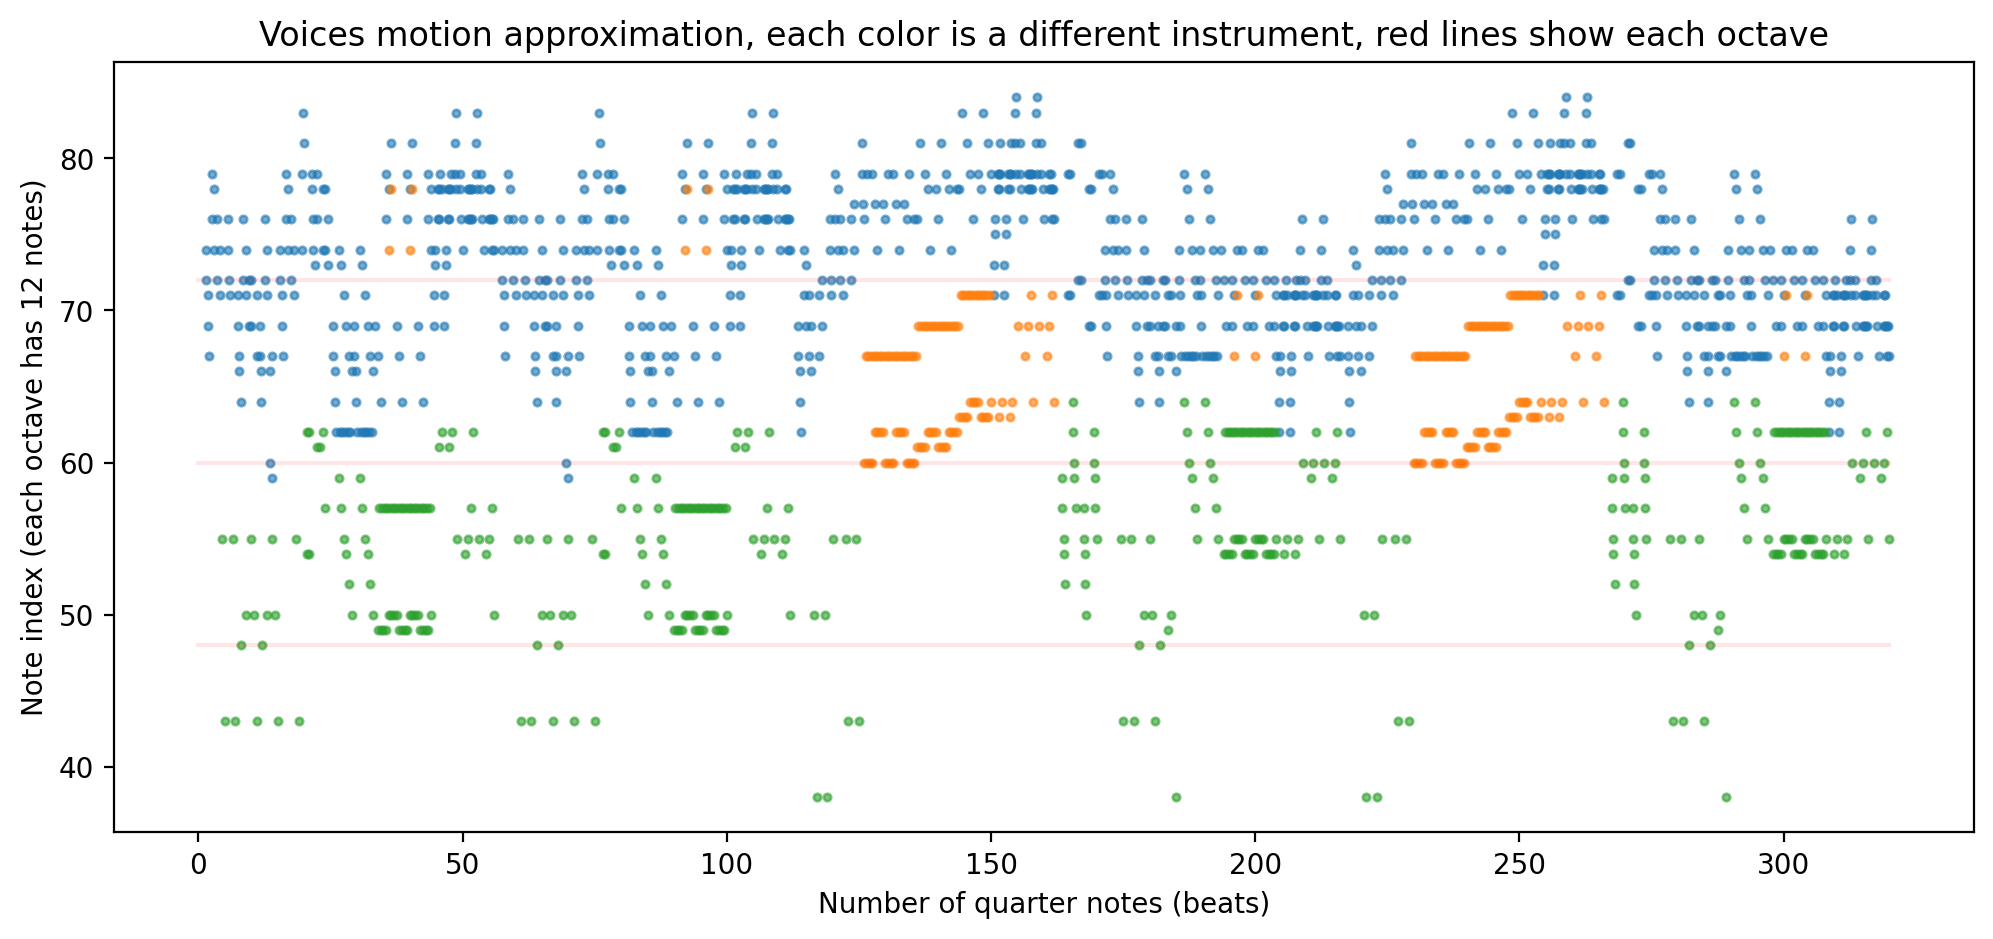

../Data/Classic/Franz Shubert/d279.png


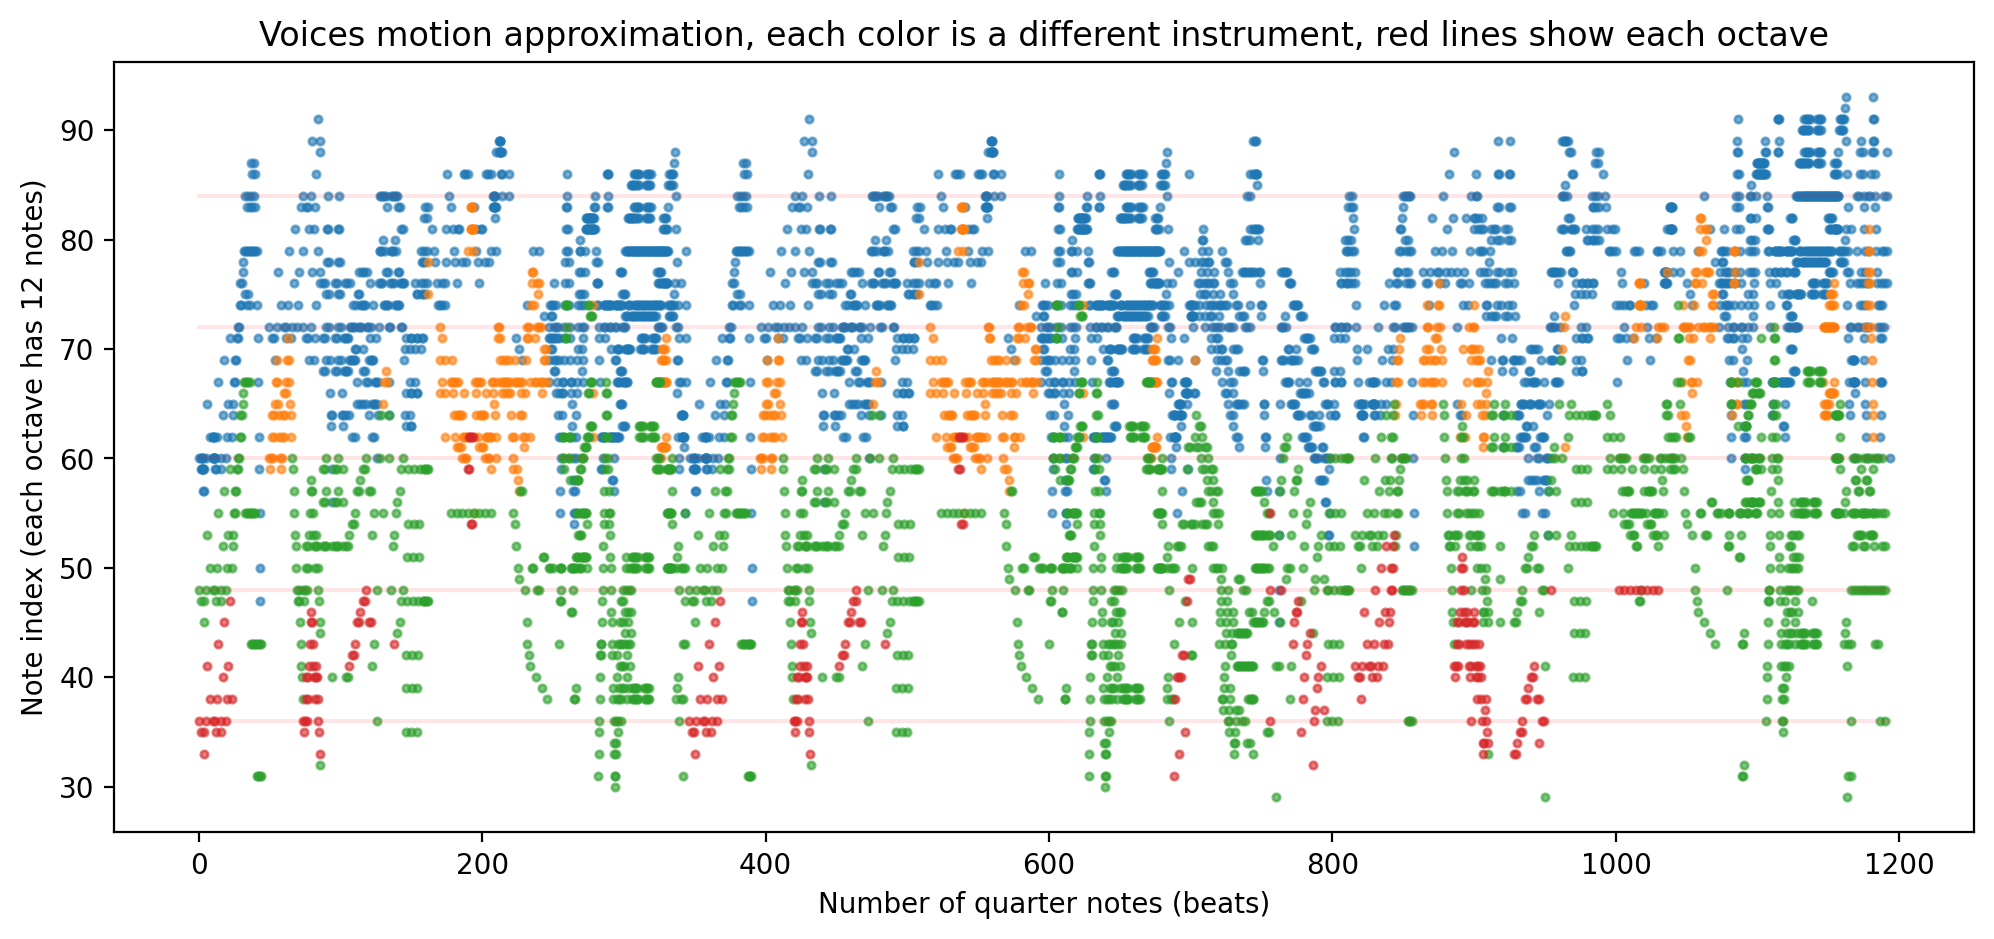

../Data/Classic/Franz Shubert/d537.png


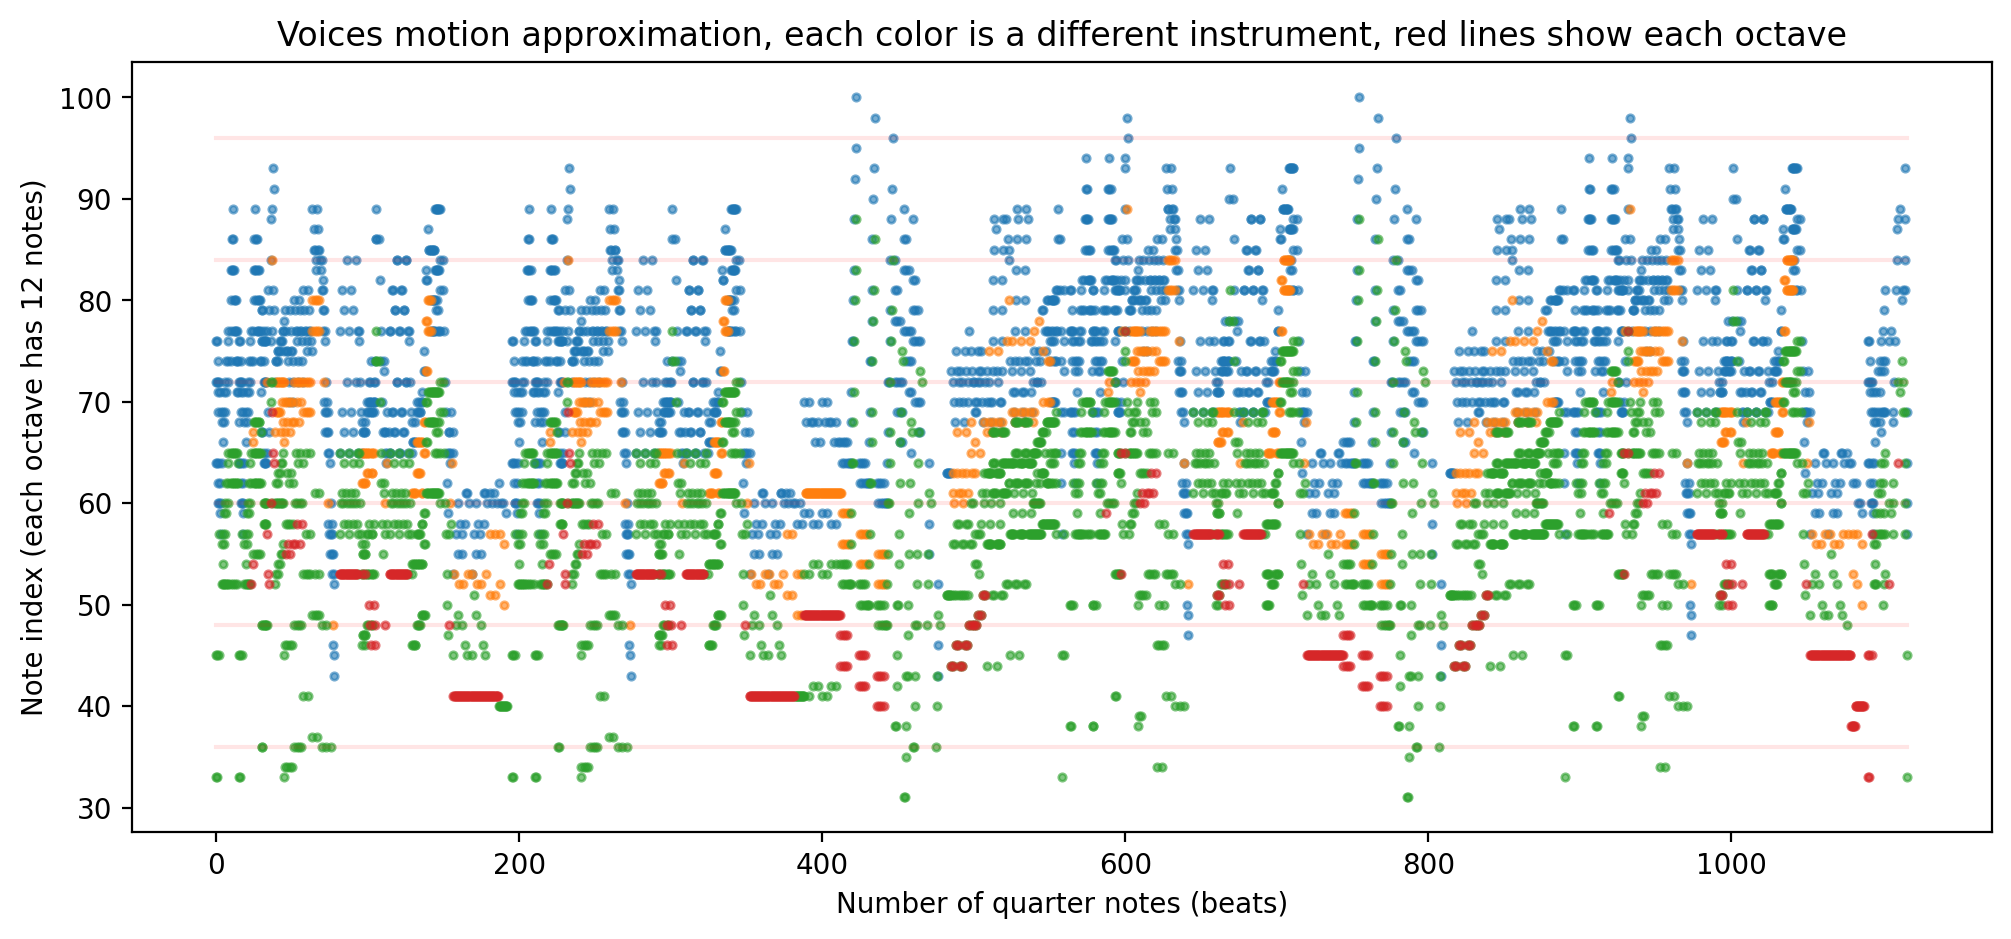

../Data/Classic/Franz Shubert/d557.png


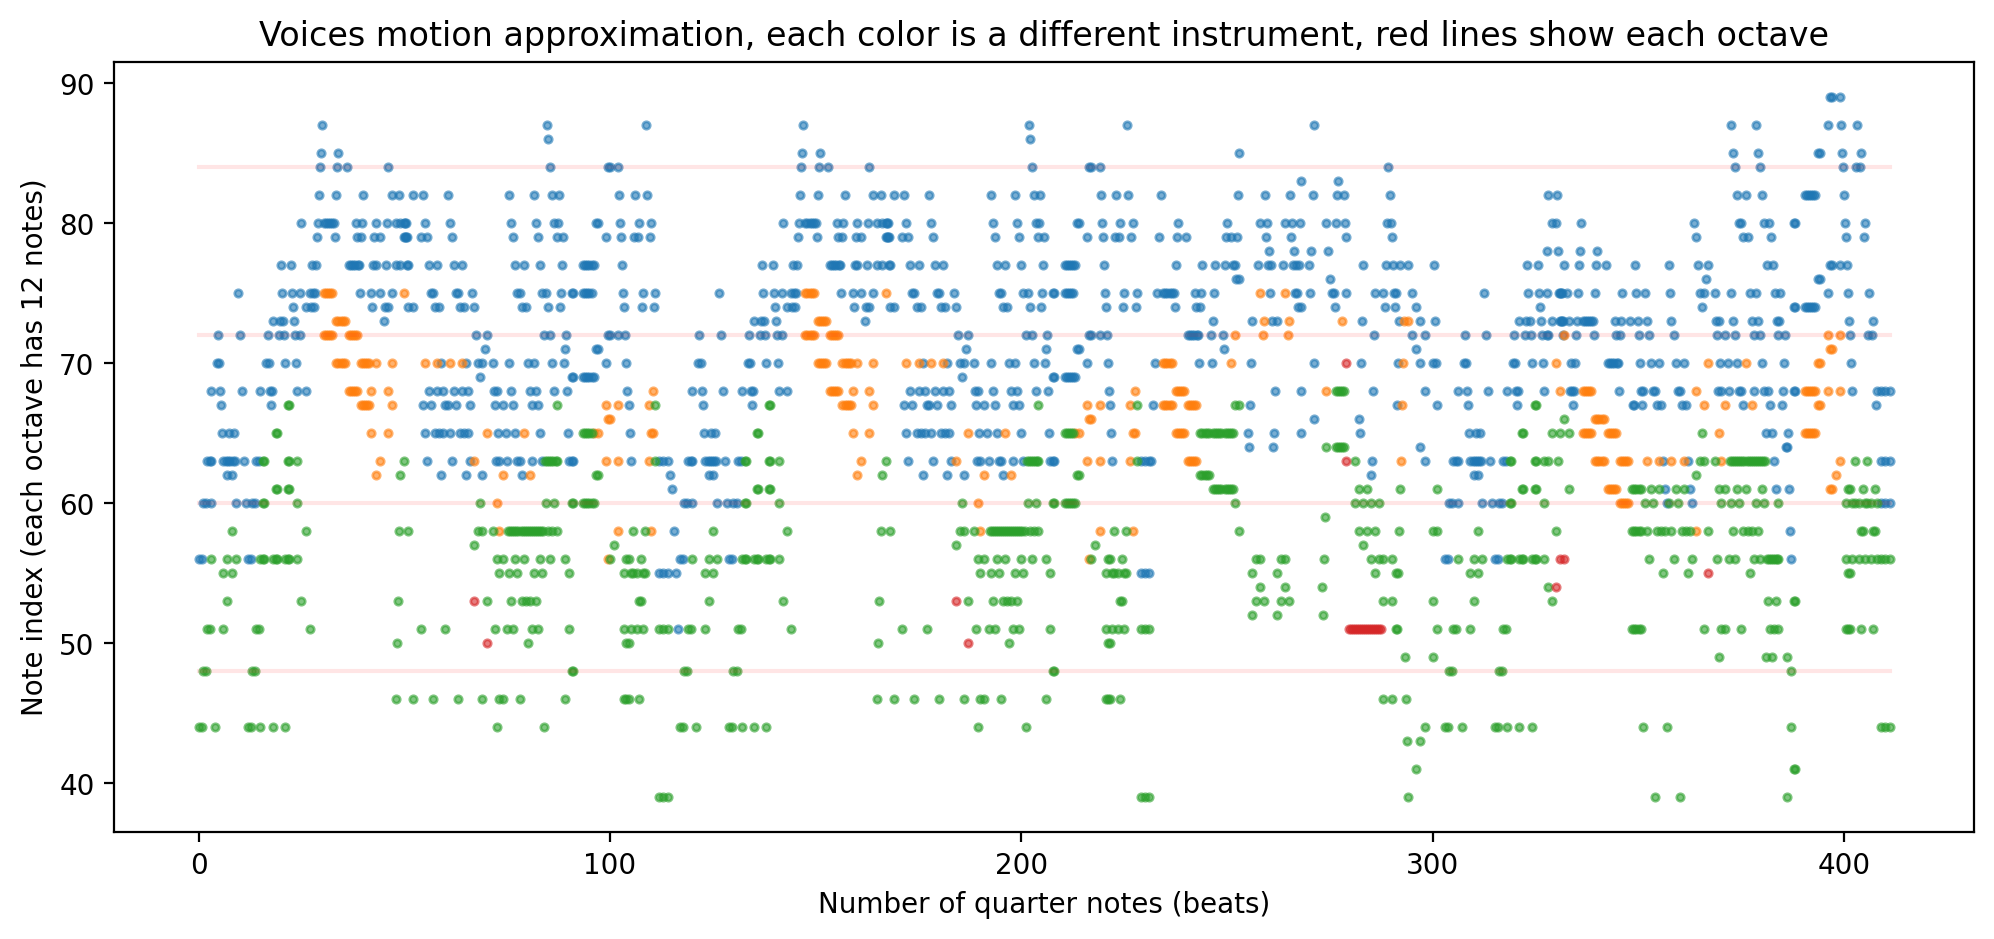

../Data/Classic/Wolfgang Amadeus Mozart/kv310.png


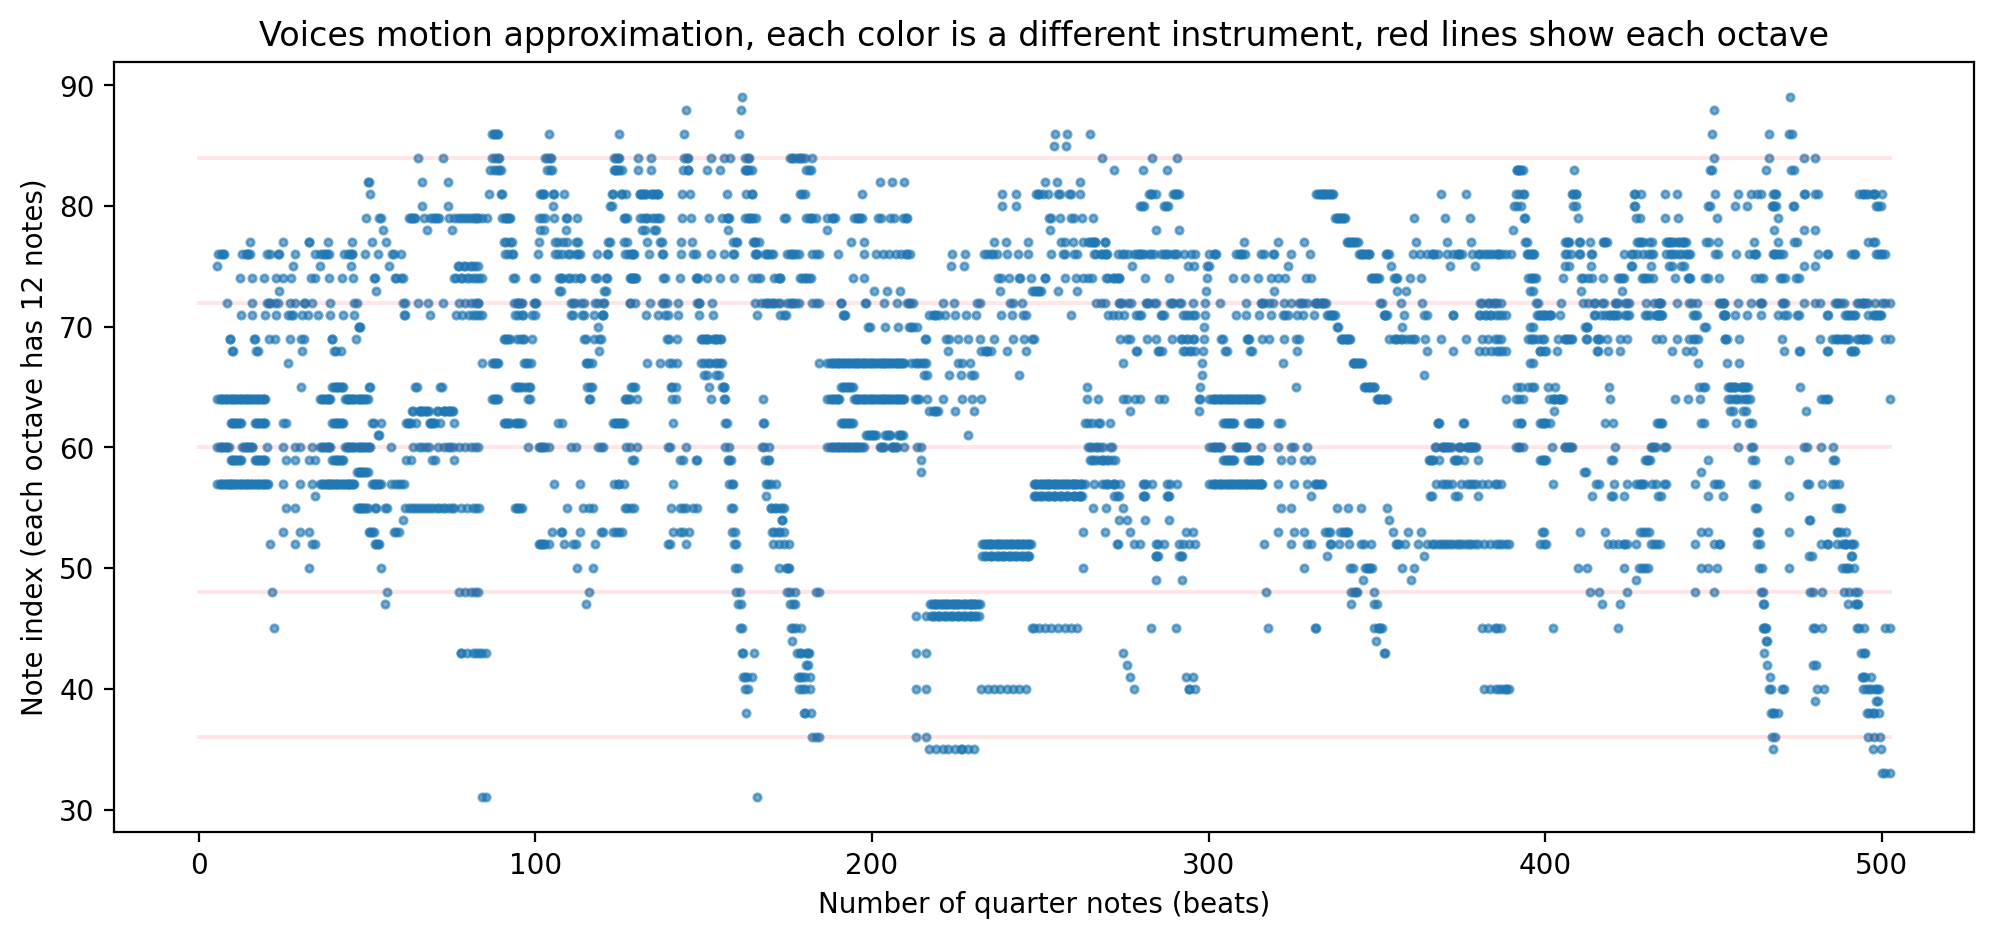

../Data/Classic/Wolfgang Amadeus Mozart/kv330.png


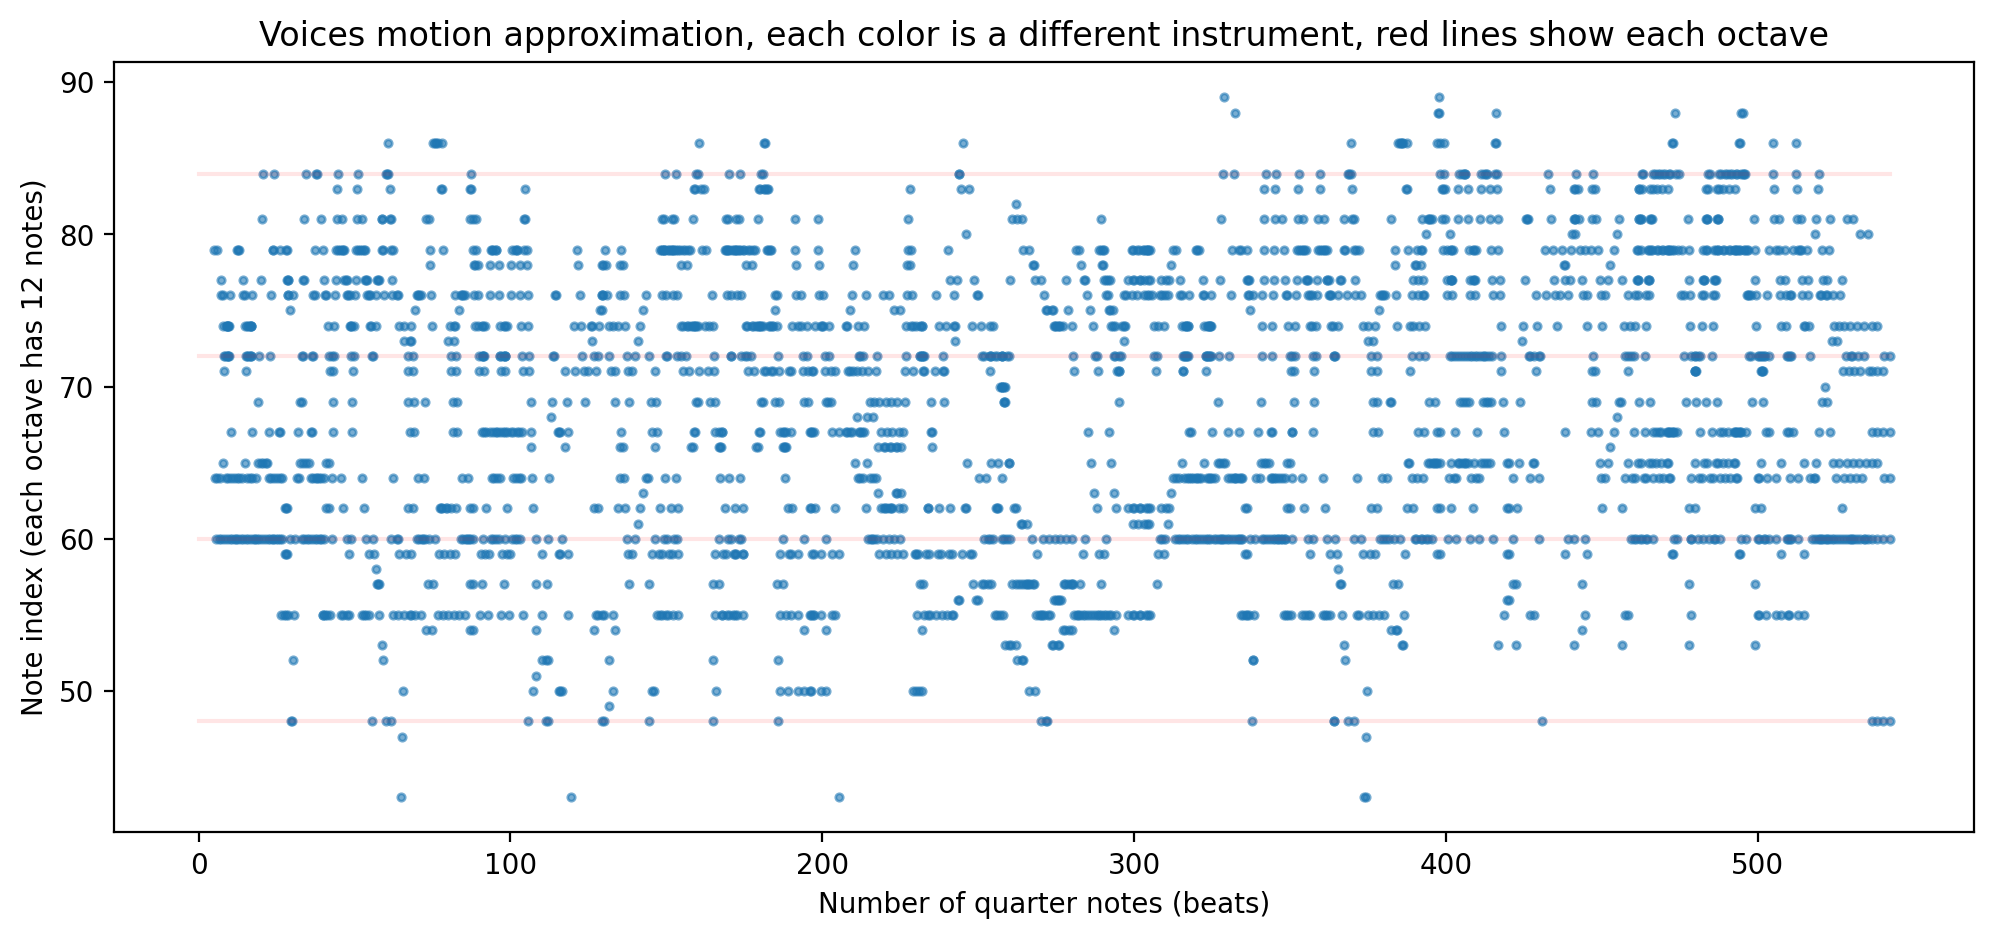

../Data/Classic/Wolfgang Amadeus Mozart/kv331.png


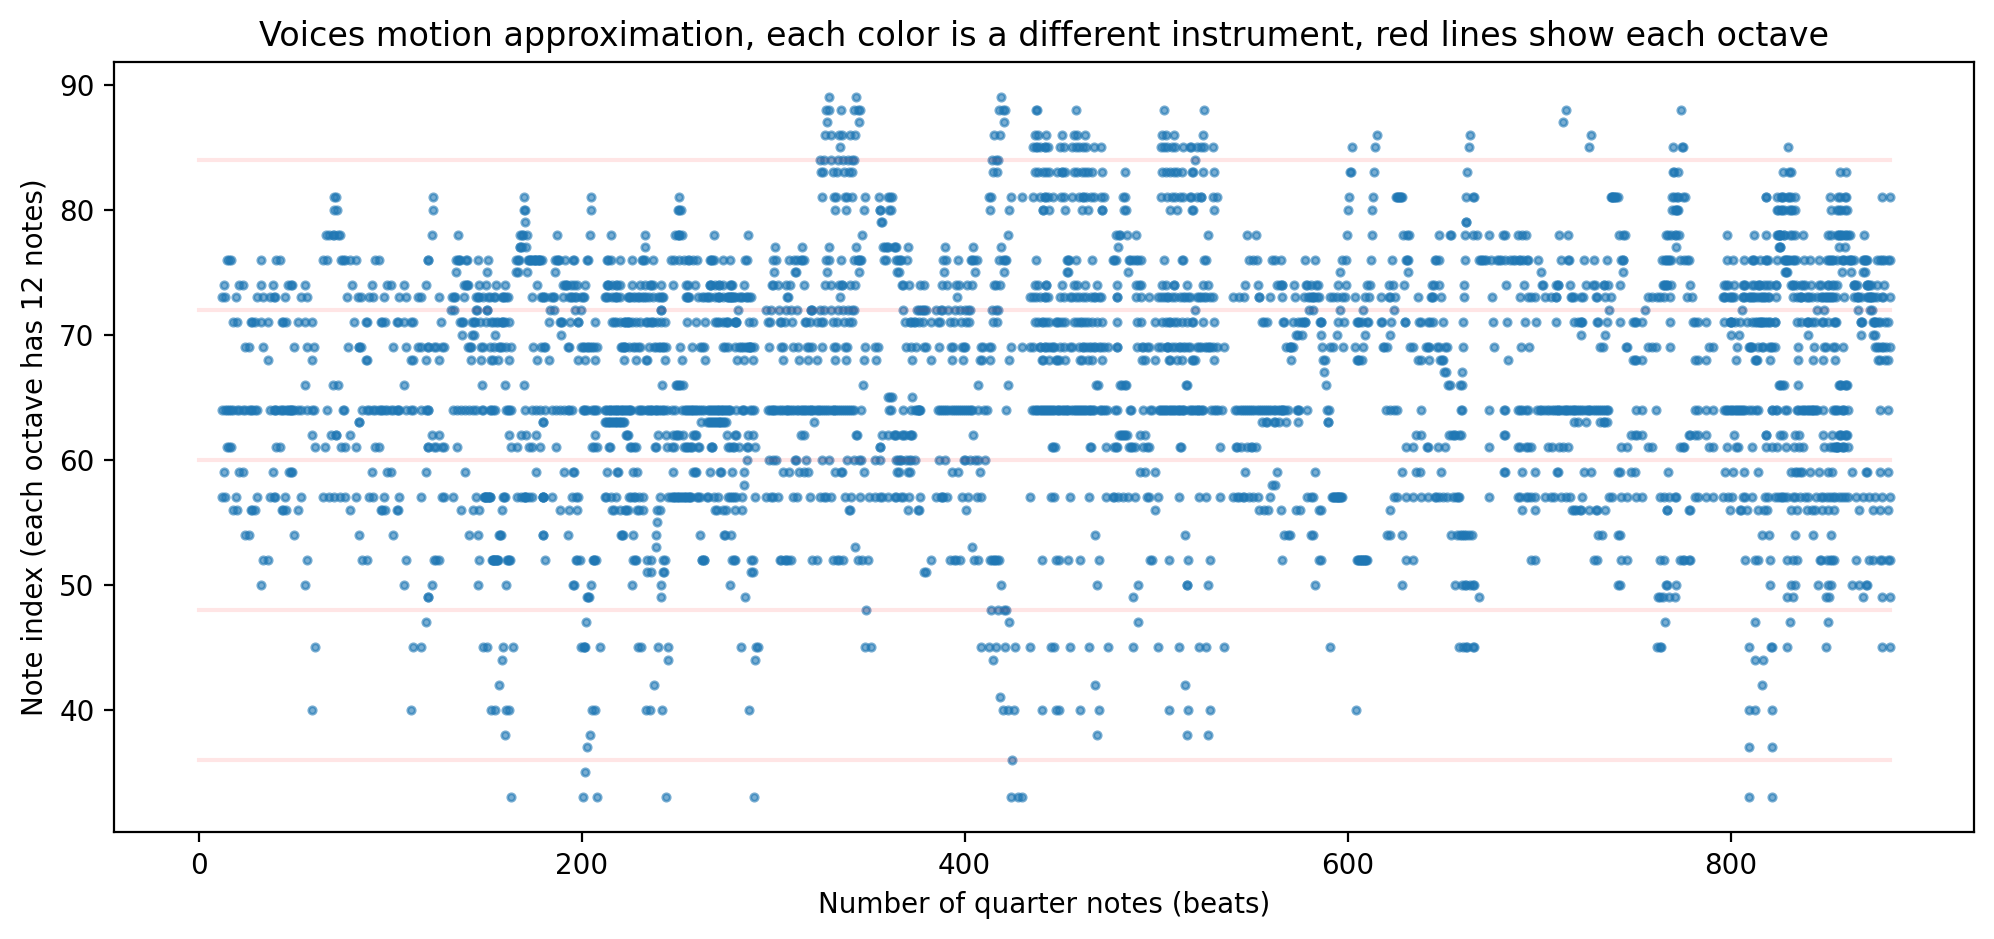

In [14]:
# Classic Data

for era, composer_dict in midi_dict.items():
    print(era)
    
    if era == "Classic":   
        
        print("Era: ", era)
        for composer, song_list in composer_dict.items():
            for i, song in enumerate(song_list):
                midi_path = path + "/" + era + "/" + composer + "/" + song_list[i]
                print(midi_path)
                midi_dict[era][composer][i]= [song_list[i],open_midi(midi_path,True)]
                
        break
        
for composer, song_list in composer_dict.items():
    for i, song in enumerate(song_list):
        midi_path = path + "/" + era + "/" + composer + "/" + song[0]   

        temp_path = "".join(midi_path.split(".")[:-1])
        jpg_path = ".." + temp_path + ".png"
        txt_path = ".." + temp_path + ".txt"

        print(jpg_path)
        
        instruments_list = list_instruments(song[1]) 
        print_parts_countour(song[1], jpg_path, txt_path, instruments_list)       

In [15]:
composer_dict

{'Bethoven': [['no1fminorop2.mid', <music21.stream.Score 0x1fc2409a580>],
  ['no2csharpminorop2.mid', <music21.stream.Score 0x1fc28608310>],
  ['no3cmmajorop2.mid', <music21.stream.Score 0x1fc2dff9880>]],
 'Franz Joseph Haydn': [['hobxvl8.mid', <music21.stream.Score 0x1fc7ae135e0>],
  ['hobxvl9.mid', <music21.stream.Score 0x1fc7bd33580>],
  ['hobxvlg1.mid', <music21.stream.Score 0x1fc805120d0>]],
 'Franz Shubert': [['d279.mid', <music21.stream.Score 0x1fc811d2580>],
  ['d537.mid', <music21.stream.Score 0x1fc83220220>],
  ['d557.mid', <music21.stream.Score 0x1fc855a4f70>]],
 'Wolfgang Amadeus Mozart': [['kv310.mid',
   <music21.stream.Score 0x1fc862aa370>],
  ['kv330.mid', <music21.stream.Score 0x1fc874c09d0>],
  ['kv331.mid', <music21.stream.Score 0x1fc885946a0>]]}